# US-Umb Parameter perturbation
 * Michigan broadleaf deciduous forest
 * 10 years, 2001-2010
 * Satellite phenology
 * 150 ensemble members, varying 6 params
     * parameters are varying in all at once (latin hypercube)

In [88]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression as lr
from sklearn.neural_network import MLPRegressor

## Parameters of interest:
* xl: leaf angle parameter (-1 = vertical, +1=horizontal)
* theta_ip: empirical curvature parameter for ap photosynthesis co-limitation
* theta_cj: empirical curvature parameter for ac, aj photosynthesis co-limitation
* wc2wjb0: the baseline ratio of rubisco-limited rate vs light-limited photosynthetic rate (Wc:Wj)
* jmaxb0: the baseline proportion of nitrogen allocated for electron transport (J)
* jmaxb1: coefficient determining the response of electron transport rate to light availability (unitless) 

## Reading in data
 * grab certain fields from every ensemble member
 * tack on forcing data only available from default case

In [89]:
# define target ensembles and variables
nx       = 150
varlist  = ['FPSN','QVEGT','Vcmx25Z','Jmx25Z','RH_LEAF','GSSUN','GSSHA']
forcing  = ['mcsec','mdcur','FSDSVD','FSDSVI','TLAI','TBOT','RH','FSDS','RAIN','SNOW','LAISUN','LAISHA']

# setting up the file path structure
dir      = '/glade/scratch/djk2120/UMBens/'
prefix   = '*LHC*'
paths    = [dir+prefix+str(exp).zfill(4)+'*.h1.*.nc' for exp in 1+np.arange(nx)]

# read and concatenate target variables
ds_list  = [xr.open_mfdataset(glob.glob(p),combine='by_coords')[varlist] for p in paths]
ensdim   = xr.DataArray(np.arange(nx), dims='ens', name='ens') # or can use np.arange
da       = xr.concat(ds_list, dim=ensdim)

# tack on forcing variables
bdir     = '/glade/scratch/djk2120/drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs/run/'
basecase = bdir+'drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs.clm2.h1.2005-01-01-00000.nc'
e0       = xr.open_dataset(basecase)
for var in forcing:
    da[var]= e0[var]
da['PREC']=e0['RAIN']+e0['SNOW']
lv  = 2.5e6  ;
rv  = 461    ;
es  = 611*np.exp(lv/rv*(1/273.16-1/da['TBOT']));
da['VPD'] = (1-da['RH']/100)*es;

In [90]:
# tack on parameter values
# add in the parameter values
dir      = '/glade/u/home/djk2120/umbcap/params/paramfiles/done/'
prefix   = 'US-UMB_GPPcap_LHC'
paths    = [dir+prefix+str(exp).zfill(4)+'.nc' for exp in 1+np.arange(nx)]
fh       = [Dataset(p, mode='r') for p in paths]
paramlist = ['xl','theta_ip','theta_cj','jmaxb0','wc2wjb0','jmaxb1']
psets = pd.DataFrame(data=np.zeros([nx,len(paramlist)]), index=None, columns=paramlist)
ixpft = 7
for i in np.arange(nx):
    p = paths[i]
    tmp = xr.open_dataset(p)
    for v in paramlist[0:5]:
        pdims = len(tmp[v].shape)
        if pdims==1:
            psets[v][i]=tmp[v][ixpft]
        elif pdims==0:
            psets[v][i]=tmp[v]
j = xr.open_dataset('/glade/scratch/djk2120/UMBens/jmaxb1.nc')
psets['jmaxb1']=j['jmaxb1']
for v in paramlist:
    da[v] = xr.DataArray(psets[v],
                  dims='ens',name=v,
                  coords={'ens': np.arange(nx)})

da

<xarray.Dataset>
Dimensions:   (ens: 150, lndgrid: 1, time: 87649)
Coordinates:
  * time      (time) datetime64[ns] 2005-01-01 ... 2015-01-01
  * ens       (ens) int64 0 1 2 3 4 5 6 7 8 ... 142 143 144 145 146 147 148 149
Dimensions without coordinates: lndgrid
Data variables:
    FPSN      (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    QVEGT     (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    Vcmx25Z   (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    Jmx25Z    (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    RH_LEAF   (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    GSSUN     (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    GSSHA     (ens, time, lndgrid) float32 dask.array<shape=(150, 87649, 1), chunksize=(1, 87649, 1)>
    mcse

In [91]:
bc = xr.open_dataset(basecase)

Text(0.5,1,'CLM5 default params')

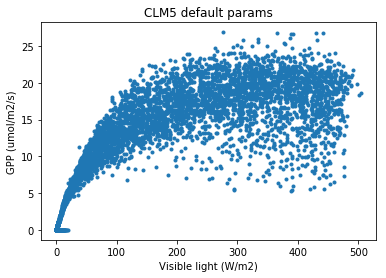

In [92]:
x=da['FSDSVD']+da['FSDSVI']
y=bc['FPSN'].values
ix = da['time.month']==7
plt.plot(x[ix],y[ix],'.')
plt.ylabel('GPP (umol/m2/s)')
plt.xlabel('Visible light (W/m2)')
plt.title('CLM5 default params')

In [93]:
gpp_max  = da['FPSN'].groupby('ens').max(dim=xr.ALL_DIMS).values
gpp_mean = da['FPSN'].groupby('ens').mean(dim=xr.ALL_DIMS).values

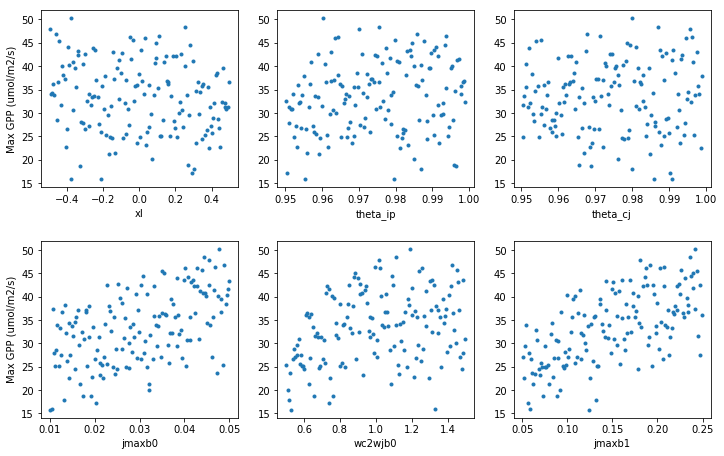

In [94]:
plt.figure(figsize=[12,7.5])
i = 0
for p in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[p],gpp_max,'.')
    plt.xlabel(p)
    if (i==1)|(i==4):
        plt.ylabel('Max GPP (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

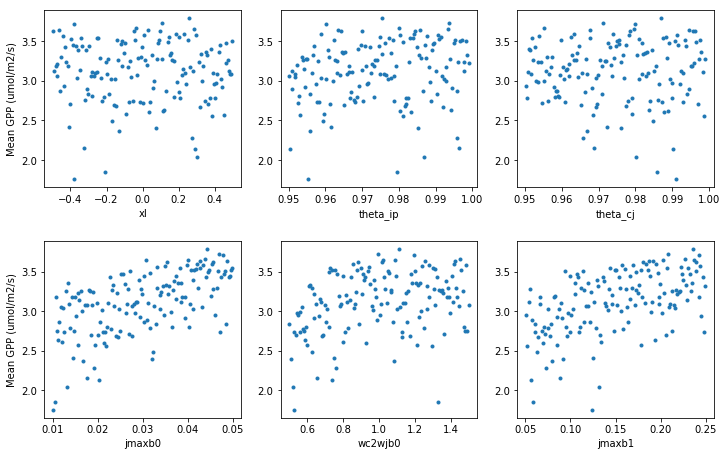

In [95]:
plt.figure(figsize=[12,7.5])
i = 0
for p in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[p],gpp_mean,'.')
    plt.xlabel(p)
    if (i==1)|(i==4):
        plt.ylabel('Mean GPP (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

In [96]:
ix = da['time.year']<2015
ee = 0
gpp_iav = [np.std(da['FPSN'].isel(ens=ee)[ix].groupby('time.year').mean(dim=xr.ALL_DIMS).values) for ee in da['ens']]

Text(0,0.5,'GPP IAV (umol/m2/s)')

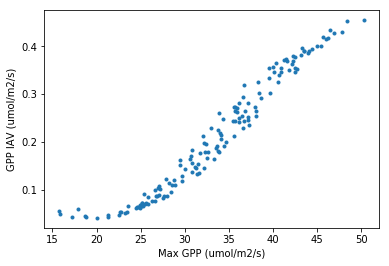

In [97]:
plt.plot(gpp_max,gpp_iav,'.')
plt.xlabel('Max GPP (umol/m2/s)')
plt.ylabel('GPP IAV (umol/m2/s)')

In [98]:
nt = np.sum(bc['FPSN'].values>0)
def f20(gpp):
    return np.sum(gpp>20)/nt
over20 = [f20(da['FPSN'].isel(ens=ee).values) for ee in da['ens']]

Text(0,0.5,'GPP IAV (umol/m2/s)')

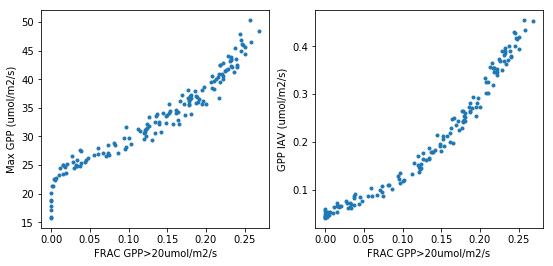

In [99]:
plt.figure(figsize=[9,4])
plt.subplot(121)
plt.plot(over20,gpp_max,'.')
plt.xlabel('FRAC GPP>20umol/m2/s')
plt.ylabel('Max GPP (umol/m2/s)')

plt.subplot(122)
plt.plot(over20,gpp_iav,'.')
plt.xlabel('FRAC GPP>20umol/m2/s')
plt.ylabel('GPP IAV (umol/m2/s)')

Text(0.5,1,'CLM5 default params')

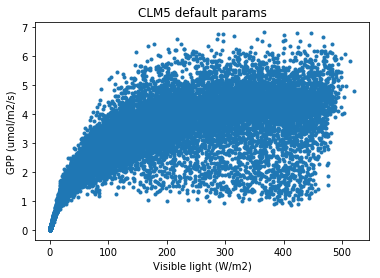

In [100]:
x=da['FSDSVD']+da['FSDSVI']
ix = np.logical_and(da['TLAI'].values>3,bc['FPSN'].values>0).ravel()
y=bc['FPSN'][ix]/da['TLAI'][ix]
plt.plot(x[ix],y,'.')
plt.ylabel('GPP (umol/m2/s)')
plt.xlabel('Visible light (W/m2)')
plt.title('CLM5 default params')

In [101]:
x=da['FSDSVD']+da['FSDSVI']
ix1 = da['TLAI'].values>3
ix2 = bc['FPSN'].values>0
ix3 = x.values>300
ix = np.logical_and(ix1,ix2)
ix = np.logical_and(ix,ix3).ravel()
v = da['VPD'].values
qq=np.quantile(v[ix],0.2)
ixv = np.logical_and(ix,(v<qq).ravel())
fcap = np.array([(da['FPSN'].isel(ens=ee)[ixv]/da['TLAI'][ixv]).mean().values for ee in da['ens']])
fcapd = (bc['FPSN'][ixv]/da['TLAI'][ixv]).mean()

In [102]:
ee = da['ens']
ixmax = fcap==fcap.max()
eemax = ee[ixmax]
ixmin = fcap==fcap.min()
eemin = ee[ixmin]


(-0.25, 12.25)

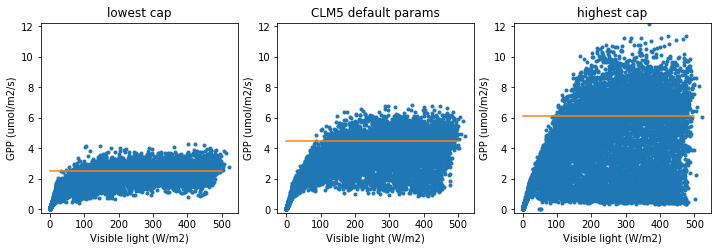

In [103]:
x=da['FSDSVD']+da['FSDSVI']
ix = np.logical_and(da['TLAI'].values>3,bc['FPSN'].values>0).ravel()
l = da['TLAI'][ix].values.ravel()
plt.figure(figsize=[12,3.5])

plt.subplot(131)
y=da['FPSN'].isel(ens=eemin).values.ravel()[ix]/l
plt.plot(x[ix],y,'.')
plt.plot([0,500],[fcap[ixmin],fcap[ixmin]])
plt.ylabel('GPP (umol/m2/s)')
plt.xlabel('Visible light (W/m2)')
plt.title('lowest cap')
plt.ylim([-0.25,12.25])


plt.subplot(133)
y=da['FPSN'].isel(ens=eemax).values.ravel()[ix]/l
plt.plot(x[ix],y,'.')
plt.plot([0,500],[fcap[ixmax],fcap[ixmax]])
plt.ylabel('GPP (umol/m2/s)')
plt.xlabel('Visible light (W/m2)')
plt.title('highest cap')
plt.ylim([-0.25,12.25])

plt.subplot(132)
y=bc['FPSN'][ix]/da['TLAI'][ix]
plt.plot(x[ix],y,'.')
plt.plot([0,500],[fcapd,fcapd])
plt.ylabel('GPP (umol/m2/s)')
plt.xlabel('Visible light (W/m2)')
plt.title('CLM5 default params')
plt.ylim([-0.25,12.25])

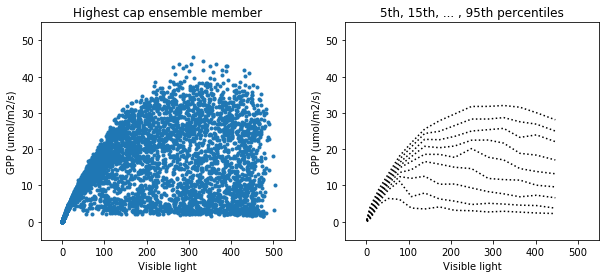

In [104]:
fmax = da['FPSN'].isel(ens=eemax).values.ravel()
x=(da['FSDSVD']+da['FSDSVI']).values.ravel()
ix = np.logical_and((fmax>0),da['time.month'].values.ravel()==7)
nw = 15
qq = np.zeros(nw+1)
qq[1:-1]=np.quantile(x[ix],0.04+np.arange(nw-1)/nw)
qq[nw]=np.inf

xq = np.zeros(nw)
out = np.zeros([nw,9])
i = -1
for qq1,qq2 in zip(qq[0:-1],qq[1:]):
    i = i+1
    ix2 = np.logical_and(x>=qq1,x<qq2)
    ix2 = np.logical_and(ix,ix2)
    xq[i] = np.mean(x[ix2])
    out[i,:]=np.quantile(fmax[ix2],0.05+np.arange(9)/10)

plt.figure(figsize=[10,4])
plt.subplot(121)
plt.plot(x[ix],fmax[ix],'.')
plt.title('Highest cap ensemble member')
plt.xlabel('Visible light')
plt.ylabel('GPP (umol/m2/s)')
plt.ylim([-5,55])
plt.xlim([-50,550])

plt.subplot(122)
plt.plot(xq,out,'k:')
plt.title('5th, 15th, ... , 95th percentiles')
plt.xlabel('Visible light')
plt.ylabel('GPP (umol/m2/s)')
plt.ylim([-5,55])
plt.xlim([-50,550])
print('')


Text(0,0.5,'sun+sha GPP (umol/m2/s)')

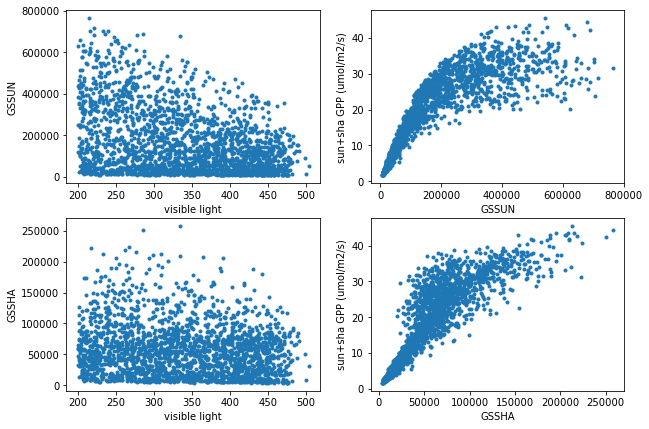

In [105]:
ix = np.logical_and(fmax>0,da['time.month']==7)
x=(da['FSDSVD']+da['FSDSVI']).values.ravel()
ix = np.logical_and(ix,x>200)
y  = da['GSSUN'].isel(ens=eemax).values.ravel()

plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(x[ix],y[ix],'.')
plt.ylabel('GSSUN')
plt.xlabel('visible light')
plt.subplot(222)
plt.plot(y[ix],fmax[ix],'.')
plt.xlabel('GSSUN')
plt.ylabel('sun+sha GPP (umol/m2/s)')

y  = da['GSSHA'].isel(ens=eemax).values.ravel()
plt.subplot(223)
plt.plot(x[ix],y[ix],'.')
plt.ylabel('GSSHA')
plt.xlabel('visible light')
plt.subplot(224)
plt.plot(y[ix],fmax[ix],'.')
plt.xlabel('GSSHA')
plt.ylabel('sun+sha GPP (umol/m2/s)')


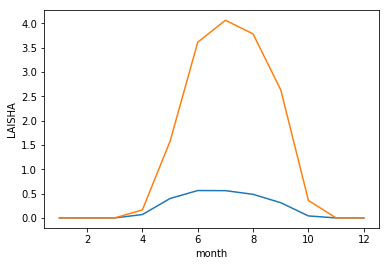

In [106]:
da['LAISUN'].groupby('time.month').mean(dim=xr.ALL_DIMS).plot()
da['LAISHA'].groupby('time.month').mean(dim=xr.ALL_DIMS).plot()

In [187]:
sorted(over20)

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.9166536111546294e-05,
 0.0008224972583424721,
 0.0021541594861350464,
 0.003211655961146796,
 0.004856650477831741,
 0.005561648127839574,
 0.010065799780667397,
 0.01131912893623688,
 0.014569951433495222,
 0.014609117969606768,
 0.014922450258499139,
 0.017507441641861195,
 0.018329938900203666,
 0.02009243302522325,
 0.02663324455585148,
 0.028317405608647973,
 0.029766567444775183,
 0.031529061569794764,
 0.03242989190036033,
 0.03360488798370672,
 0.033800720664264455,
 0.03677737740874197,
 0.03767820773930754,
 0.037756540811530626,
 0.038344038853203824,
 0.04323985586714711,
 0.044532351558828134,
 0.04766567444775184,
 0.054989816700611,
 0.0597289675701081,
 0.060120632931223564,
 0.06662227792574024,
 0.0708130972896757,
 0.07320225599248002,
 0.07382892057026477,
 0.07449475168416106,
 0.08064389785367382,
 0.08217139276202412,
 0.08651887827040576,
 0.09349052169826101,
 0.09552718157606141,
 0.09631051229829234,
 0.09658467805107317

/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190723/lib/python3.6/site-packages/xarray/core/groupby.py:713: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)
/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190723/lib/python3.6/site-packages/dask/array/numpy_compat.py:38: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


Text(0.5,1,'High-cap ensemble member: 2006')

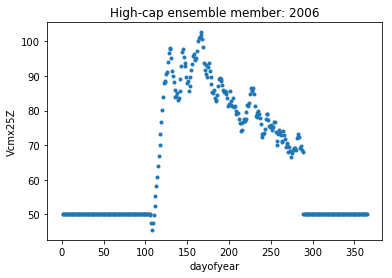

In [163]:
ix = da['time.year']==2006
da['Vcmx25Z'].isel(ens=eemax).where(ix).groupby('time.dayofyear').mean().plot.line('.')
plt.title('High-cap ensemble member: 2006')

In [193]:
20*(1+np.arange(6))

array([ 20,  40,  60,  80, 100, 120])

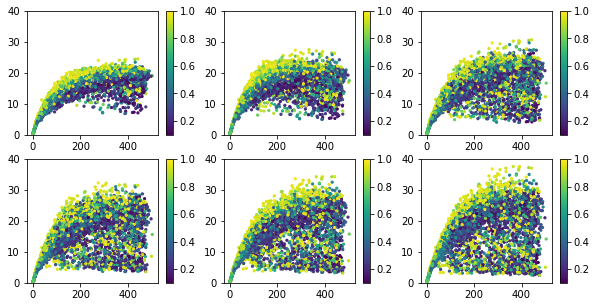

In [197]:
ix = np.logical_and(f>0,da['time.month']==7)
x=(da['FSDSVD']+da['FSDSVI']).values.ravel()
dff = (da['FSDSVI']/ (da['FSDSVD']+da['FSDSVI'])).values.ravel()

oo = sorted(over20)
i = 0
plt.figure(figsize=[10,5])
for ii in 2+20*(1+np.arange(6)):
    i = i+1
    plt.subplot(2,3,i)
    ee = da['ens'][over20==oo[ii]]
    f = da['FPSN'].isel(ens=ee).values.ravel()
    plt.scatter(x[ix],f[ix],s=5,c=dff[ix])
    plt.ylim([0,40])
    plt.colorbar()

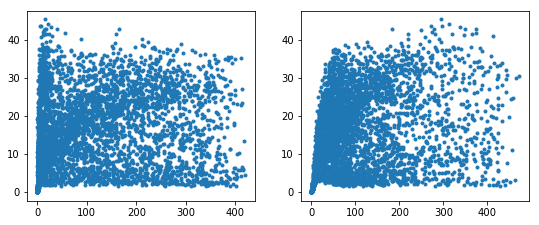

In [183]:
plt.figure(figsize=[9,3.5])
plt.subplot(121)
plt.plot(da['FSDSVD'][ix],fmax[ix],'.')
plt.subplot(122)
plt.plot(da['FSDSVI'][ix],fmax[ix],'.')

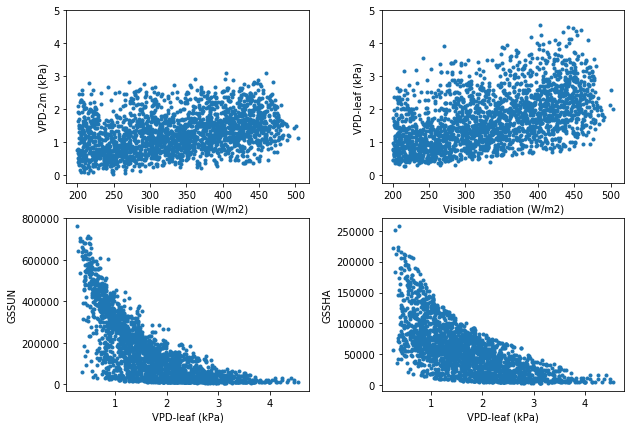

In [107]:
ix = np.logical_and(fmax>0,da['time.month']==7)
x=(da['FSDSVD']+da['FSDSVI']).values.ravel()
v  = da['RH_LEAF'].isel(ens=eemax).values.ravel() 
v0  = da['VPD'].values.ravel()/1000
ix = np.logical_and(ix,x>200)


plt.figure(figsize=[10,7])
plt.subplot(221)
plt.plot(x[ix],v0[ix],'.')
plt.ylim([-0.25,5])
plt.xlabel('Visible radiation (W/m2)')
plt.ylabel('VPD-2m (kPa)')
plt.subplot(222)
plt.plot(x[ix],v[ix],'.')
plt.ylim([-0.25,5])
plt.xlabel('Visible radiation (W/m2)')
plt.ylabel('VPD-leaf (kPa)')
plt.subplot(223)
y  = da['GSSUN'].isel(ens=eemax).values.ravel()
plt.plot(v[ix],y[ix],'.')
plt.ylabel('GSSUN')
plt.xlabel('VPD-leaf (kPa)')
plt.subplot(224)
y  = da['GSSHA'].isel(ens=eemax).values.ravel()
plt.plot(v[ix],y[ix],'.')
plt.ylabel('GSSHA')
plt.xlabel('VPD-leaf (kPa)')
plt.subplots_adjust(wspace=0.3)

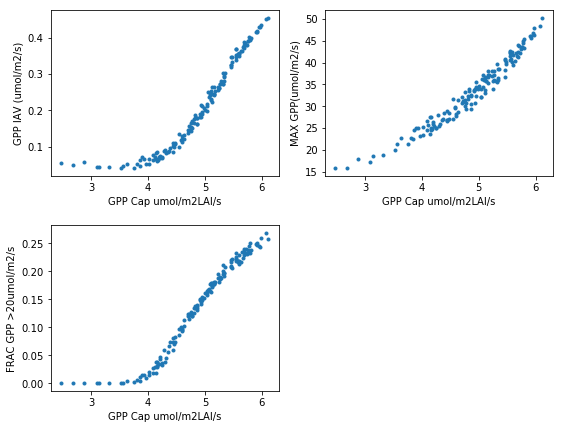

In [108]:
plt.figure(figsize=[9,7])
plt.subplot(221)
plt.plot(fcap,gpp_iav,'.')
plt.xlabel('GPP Cap umol/m2LAI/s')
plt.ylabel('GPP IAV (umol/m2/s)')
plt.subplot(222)
plt.plot(fcap,gpp_max,'.')
plt.xlabel('GPP Cap umol/m2LAI/s')
plt.ylabel('MAX GPP(umol/m2/s)')
plt.subplot(223)
plt.plot(fcap,over20,'.')
plt.xlabel('GPP Cap umol/m2LAI/s')
plt.ylabel('FRAC GPP >20umol/m2/s')
plt.subplots_adjust(hspace=0.3)

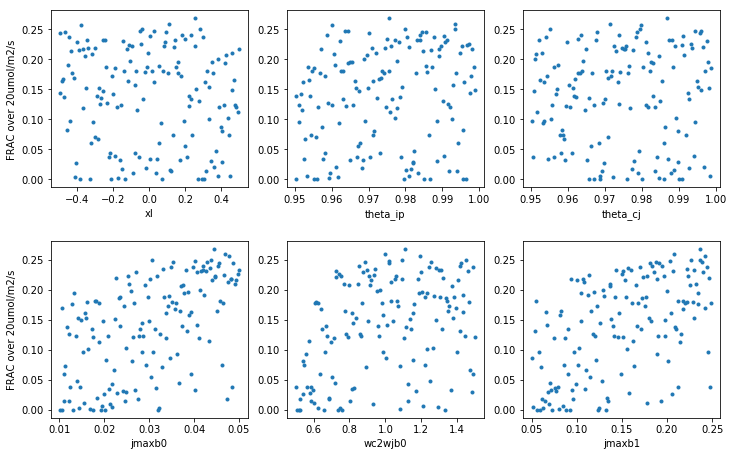

In [109]:
i=0
plt.figure(figsize=[12,7.5])
for p in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[p],over20,'.')
    plt.xlabel(p)
    if (i==1)|(i==4):
        plt.ylabel('FRAC over 20umol/m2/s')
plt.subplots_adjust(hspace=0.3)

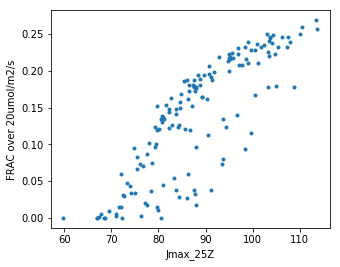

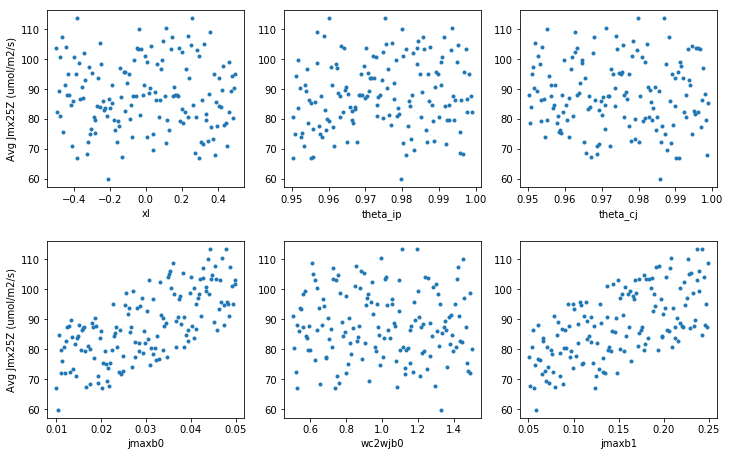

In [110]:
javg = da['Jmx25Z'].groupby('ens').mean(dim=xr.ALL_DIMS).values
plt.figure(figsize=[5,4])
plt.plot(javg,over20,'.')
plt.xlabel('Jmax_25Z')
plt.ylabel('FRAC over 20umol/m2/s')
plt.figure(figsize=[12,7.5])
i = 0
for p in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[p],javg,'.')
    plt.xlabel(p)
    if (i==1)|(i==4):
        plt.ylabel('Avg Jmx25Z (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)

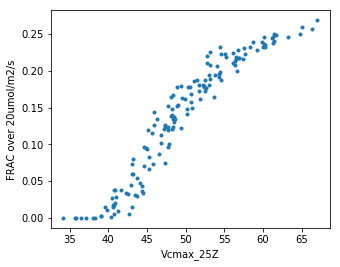

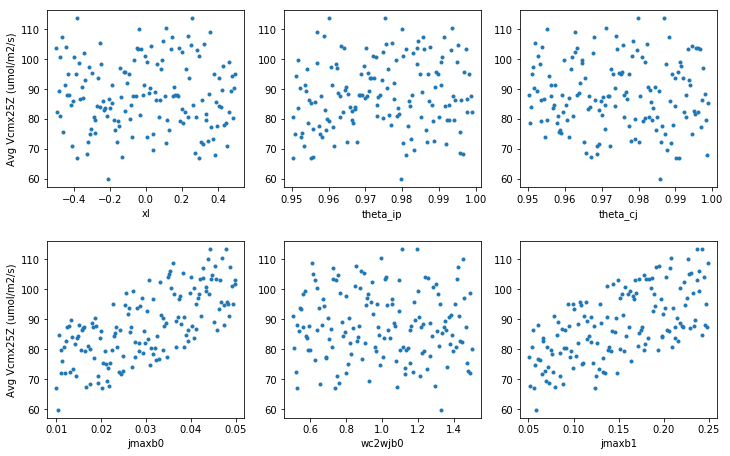

In [111]:
vcavg = (da['Vcmx25Z']).groupby('ens').mean(dim=xr.ALL_DIMS).values
plt.figure(figsize=[5,4])
plt.plot(vcavg,over20,'.')
plt.xlabel('Vcmax_25Z')
plt.ylabel('FRAC over 20umol/m2/s')
plt.figure(figsize=[12,7.5])
i = 0
for p in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[p],javg,'.')
    plt.xlabel(p)
    if (i==1)|(i==4):
        plt.ylabel('Avg Vcmx25Z (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)


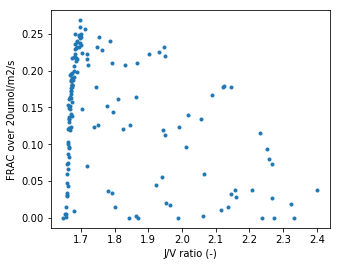

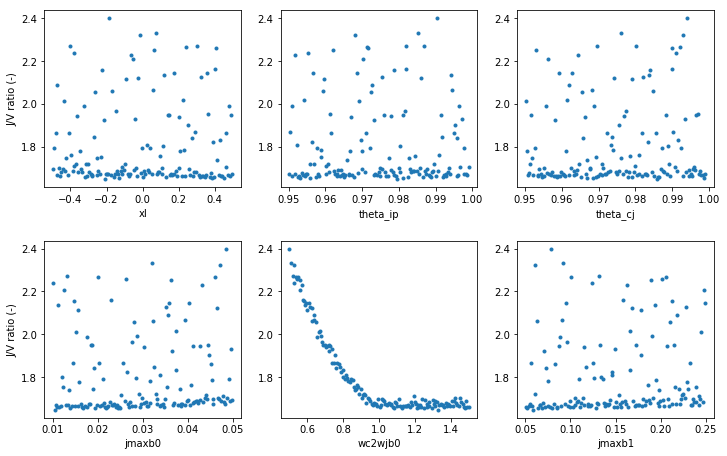

In [112]:
jvratio = (da['Jmx25Z']/da['Vcmx25Z']).groupby('ens').mean(dim=xr.ALL_DIMS).values

plt.figure(figsize=[5,4])
plt.plot(jvratio,over20,'.')
plt.xlabel('J/V ratio (-)')
plt.ylabel('FRAC over 20umol/m2/s')

plt.figure(figsize=[12,7.5])
i = 0
for p in paramlist:
    i = i+1
    plt.subplot(2,3,i)
    plt.plot(da[p],jvratio,'.')
    plt.xlabel(p)
    if (i==1)|(i==4):
        plt.ylabel('J/V ratio (-)')
plt.subplots_adjust(hspace=0.3)

Text(0,0.5,'Vcmx25Z (umol/m2/s)')

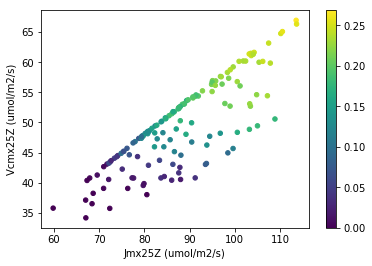

In [113]:
plt.scatter(javg,vcavg,s=20,c=over20)
plt.colorbar()
plt.xlabel('Jmx25Z (umol/m2/s)')
plt.ylabel('Vcmx25Z (umol/m2/s)')

## Train an emulator
* tease out partial responses and interactions

In [114]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

Text(0.5,1,'R=0.96  RMSE=0.02')

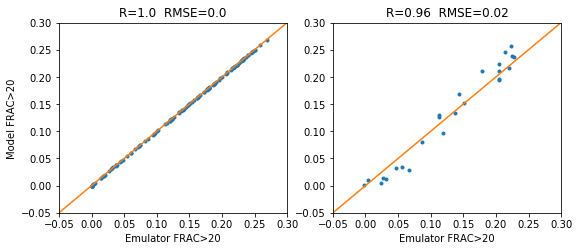

In [212]:
mins = da[paramlist].min()
maxs = da[paramlist].max()
ix = da['ens']<125
X = np.hstack((da[p].values[ix].reshape(-1,1)-mins[p].values)/(maxs[p].values-mins[p].values) for p in paramlist)
# Observations
y = np.array(over20)[ix].reshape(-1,1)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Look at training relationship
y_pred, sigma = gp.predict(X, return_std=True)
rmse = np.round(np.sqrt(np.mean(np.square(y_pred-y))),2)
r    = np.round(gp.score(X,y),2)

plt.figure(figsize=[9,3.5])
plt.subplot(121)
plt.plot(y_pred,y,'.')
the_lims=[-0.05,0.3]
plt.plot(the_lims,the_lims)
plt.xlim(the_lims)
plt.ylim(the_lims)
plt.xlabel('Emulator FRAC>20')
plt.ylabel('Model FRAC>20')
plt.title('R='+str(r)+'  RMSE='+str(rmse))

ix = da['ens']>=125
X = np.hstack((da[p].values[ix].reshape(-1,1)-mins[p].values)/(maxs[p].values-mins[p].values) for p in paramlist)
y = np.array(over20)[ix].reshape(-1,1)
y_pred, sigma = gp.predict(X, return_std=True)
rmse = np.round(np.sqrt(np.mean(np.square(y_pred-y))),2)
r    = np.round(gp.score(X,y),2)
plt.subplot(122)
plt.plot(y_pred,y,'.')
the_lims=[-0.05,0.3]
plt.plot(the_lims,the_lims)
plt.xlim(the_lims)
plt.ylim(the_lims)
plt.xlabel('Emulator FRAC>20')
plt.title('R='+str(r)+'  RMSE='+str(rmse))



<xarray.DataArray 'ens' ()>
array(125)
R=1.0  RMSE=0.0


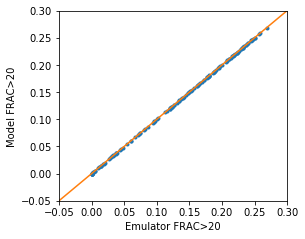

R=1.0  RMSE=0.0


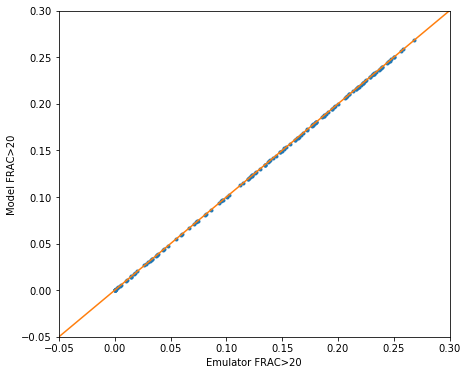

In [115]:
mins = da[paramlist].min()
maxs = da[paramlist].max()
X = np.hstack((da[p].values.reshape(-1,1)-mins[p].values)/(maxs[p].values-mins[p].values) for p in paramlist)

# Observations
y = np.array(over20).reshape(-1,1)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gp.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gp.predict(X, return_std=True)
rmse = np.round(np.sqrt(np.mean(np.square(y_pred-y))),2)
r    = np.round(gp.score(X,y),2)

plt.figure(figsize=[7,6])
plt.plot(y_pred,y,'.')
the_lims=[-0.05,0.3]
plt.plot(the_lims,the_lims)
plt.xlim(the_lims)
plt.ylim(the_lims)
plt.xlabel('Emulator FRAC>20')
plt.ylabel('Model FRAC>20')

print('R='+str(r)+'  RMSE='+str(rmse))

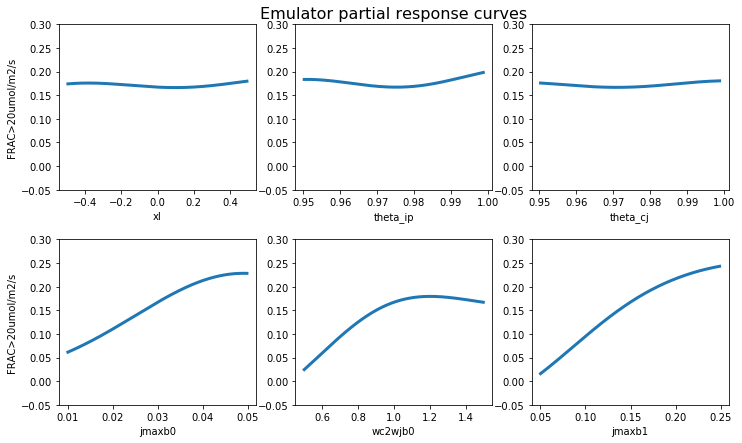

In [116]:
plt.figure(figsize=[12,7])
for i in np.arange(6):
    p = paramlist[i]
    X_test = 0.5+np.zeros([400,6])
    x = np.arange(400)/400
    X_test[:,i]=x
    x = mins[p].values+x*(maxs[p].values-mins[p].values)
    y_pred = gp.predict(X_test)
    plt.subplot(2,3,i+1)
    plt.plot(x,y_pred,linewidth=3)
    plt.xlabel(p)
    plt.ylim(the_lims)
    if i==1:
        plt.title('Emulator partial response curves',fontsize=16)
    if (i==0)|(i==3):
        plt.ylabel('FRAC>20umol/m2/s')
plt.subplots_adjust(hspace=0.3)

Text(0.5,0,'wc2wjb0')

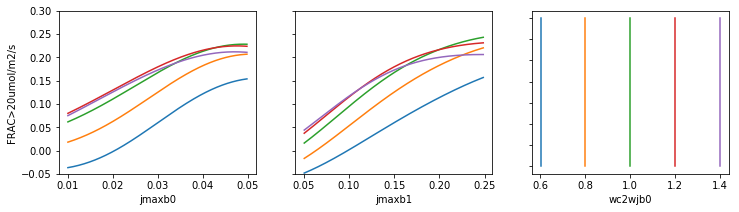

In [117]:
plt.figure(figsize=[12,3])
pairs = [(3,4),(5,4)]
j = 0
for pair in pairs:
    j = j+1
    plt.subplot(1,3,j)
    for i in np.arange(5):
        p1 = pair[0]
        p  = paramlist[p1]
        p2 = pair[1]
        X_test = 0.5+np.zeros([400,6])
        x = np.arange(400)/400
        X_test[:,p1]=x
        X_test[:,p2]=0.1+0.2*i
        x = x*(maxs[p].values-mins[p].values)+mins[p].values
        y = gp.predict(X_test)
        plt.plot(x,y)
        plt.ylim(the_lims)
    if j==1:
        plt.ylabel('FRAC>20umol/m2/s')
        plt.xlabel(p)       
    else:
        frame1 = plt.gca()
        frame1.axes.yaxis.set_ticklabels([])
        plt.xlabel(p)

plt.subplot(133)
p = 'wc2wjb0'
for i in np.arange(5):
    wc = 0.1+0.2*i*(maxs[p].values-mins[p].values)+mins[p].values
    plt.plot([wc,wc],the_lims)
frame1 = plt.gca()
frame1.axes.yaxis.set_ticklabels([])
plt.xlabel(p)

/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190723/lib/python3.6/site-packages/sklearn/gaussian_process/gpr.py:346: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


R=1.0  RMSE=0.0


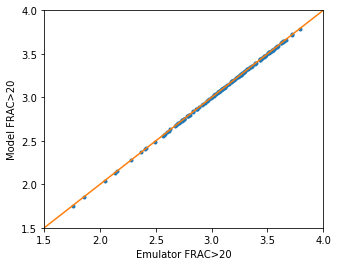

In [118]:
mins = da[paramlist].min()
maxs = da[paramlist].max()
X = np.hstack((da[p].values.reshape(-1,1)-mins[p].values)/(maxs[p].values-mins[p].values) for p in paramlist)

# Observations
y = gpp_mean.reshape(-1,1)

# Instantiate a Gaussian Process model
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))
gpmean = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

# Fit to data using Maximum Likelihood Estimation of the parameters
gpmean.fit(X, y)

# Make the prediction on the meshed x-axis (ask for MSE as well)
y_pred, sigma = gpmean.predict(X, return_std=True)
rmse = np.round(np.sqrt(np.mean(np.square(y_pred-y))),2)
r    = np.round(gpmean.score(X,y),2)

plt.figure(figsize=[5,4])
plt.plot(y_pred,y,'.')
the_lims=[1.5,4]
plt.plot(the_lims,the_lims)
plt.xlim(the_lims)
plt.ylim(the_lims)
plt.xlabel('Emulator FRAC>20')
plt.ylabel('Model FRAC>20')

print('R='+str(r)+'  RMSE='+str(rmse))

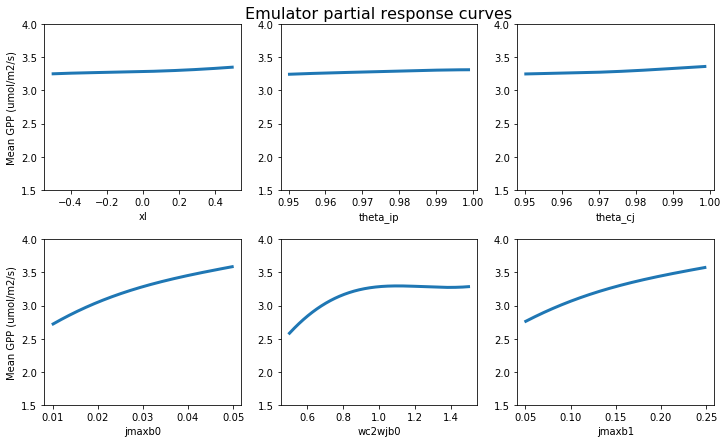

In [119]:
plt.figure(figsize=[12,7])
for i in np.arange(6):
    p = paramlist[i]
    X_test = 0.5+np.zeros([400,6])
    x = np.arange(400)/400
    X_test[:,i]=x
    x = mins[p].values+x*(maxs[p].values-mins[p].values)
    y_pred = gpmean.predict(X_test)
    plt.subplot(2,3,i+1)
    plt.plot(x,y_pred,linewidth=3)
    plt.xlabel(p)
    plt.ylim(the_lims)
    if i==1:
        plt.title('Emulator partial response curves',fontsize=16)
    if (i==0)|(i==3):
        plt.ylabel('Mean GPP (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)